# Part 1

In [2]:
import numpy as np
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def imae(x,y): return (abs(x-y)).mean()

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def print_score(m):
    maer = [imae(m.predict(X_train), y_train), imae(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): maer.append(m.oob_score_)
    print(maer)

def numericalize(df, col, name, max_n_cat):
    if not  pd.api.types.is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def fix_missing(df, col, name, na_dict):
    if  pd.api.types.is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not pd.api.types.is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Part 2

In [3]:
TRAIN_FILE='/home/thiago.martinelli/code/main/data/pubg/train_V2.csv'
TEST_FILE='/home/thiago.martinelli/code/main/data/pubg/test_V2.csv'

In [12]:
df_raw = pd.read_csv(TRAIN_FILE, engine='python')

In [20]:
df, _, _ = proc_df(df_raw)

In [21]:
train_cats(df)

# l_______________________________________________________________l

# l_______________________________________________________________l

## Carregar dataset pré-processado

In [4]:
import tables
PATH = '/home/thiago.martinelli/data/kaggle/pubg/'

data_store = pd.HDFStore(PATH+ 'train.h5')
df = data_store['preprocessed_df']
data_store.close()

# l_______________________________________________________________l

In [49]:
df0 = df

In [50]:
%%time
df0.set_index(['matchId','kills','killPlace','groupId'], drop=False, inplace = True)

CPU times: user 4.86 s, sys: 988 ms, total: 5.85 s
Wall time: 5.87 s


In [51]:
%%time
df0.sort_index(level=(0,1,2,3), inplace=True)

CPU times: user 38.4 s, sys: 4.95 s, total: 43.4 s
Wall time: 1min 25s


In [52]:
df0['matchId'].value_counts()

4094     100
5479     100
1368     100
17746    100
11949    100
25936    100
9561     100
42358    100
42359    100
13664    100
9509     100
16034    100
17763    100
5486     100
38241    100
40625    100
5495     100
38250    100
34116    100
13652    100
46425    100
34142    100
9505     100
44705    100
28350    100
21807    100
38196    100
46398    100
44710    100
42296    100
        ... 
29031      8
34472      8
25996      8
42302      8
10298      8
36169      8
25262      8
21297      8
45011      8
31739      8
10291      8
42567      8
25291      7
45781      7
35201      7
40758      7
28701      7
4279       7
6658       7
5773       7
19218      7
23304      7
9378       7
1978       7
20940      7
29740      6
10702      6
25876      5
42910      2
6341       1
Name: matchId, Length: 47965, dtype: int64

In [53]:
df0.shape

(4446966, 30)

In [54]:
%%time
data_store = pd.HDFStore(PATH + 'train.h5')
data_store['sorted_df'] = df0
data_store.close()

# l_______________________________________________________________l

# Dataset préprocessado salvo. A partir daqui vou continuar em outro notebook.

# l_______________________________________________________________l

In [14]:
df1 = df_raw.set_index('matchId',drop=False)

In [15]:
df2 = df1.sort_index()

In [16]:
df3 = df2.iloc[:55500,:]

In [17]:
matches=dict(df3.index.value_counts())

In [18]:
for match in set(df3.index):
    if match not in m:
        print(match)
        df4=df3.drop(match,axis=0)

NameError: name 'm' is not defined

In [19]:
df4 = df3.set_index(['matchId','kills','killPlace','groupId'], drop=False)

In [20]:
df5 = df4.sort_index(level=(0,1,2,3))

In [21]:
df5.head()

Id         groupId  \
matchId        kills killPlace groupId                                          
0000a43bce5eec 0     36        c0f2e306380d3c  ccb5a67f210a08  c0f2e306380d3c   
                     37        6620b219ed2ee2  b66a690a2c32f9  6620b219ed2ee2   
                     38        6620b219ed2ee2  a638435c730f4e  6620b219ed2ee2   
                     39        b947dfc5cf2d02  c63253392e4fbb  b947dfc5cf2d02   
                     40        7bd08592bb25e2  7a5595685078c5  7bd08592bb25e2   

                                                      matchId  assists  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c  0000a43bce5eec        0   
                     37        6620b219ed2ee2  0000a43bce5eec        1   
                     38        6620b219ed2ee2  0000a43bce5eec        1   
                     39        b947dfc5cf2d02  0000a43bce5eec        0   
                     40        7bd08592bb25e2  0000a43bce5eec        2   

                                               boosts  damageDealt  DBNOs  \
matchId        kills killPlace groupId                                      
0000a43bce5eec 0     36        c0f2e306380d3c       4        57.32      0   
                     37        6620b219ed2ee2       2       155.50      0   
                     38        6620b219ed2ee2       1       256.10      3   
                     39        b947dfc5cf2d02       0         0.00      0   
                     40        7bd08592bb25e2       1       211.90      0   

                                               headshotKills  heals  \
matchId        kills killPlace groupId                                
0000a43bce5eec 0     36        c0f2e306380d3c              0      1   
                     37        6620b219ed2ee2              0      2   
                     38        6620b219ed2ee2              0      0   
                     39        b947dfc5cf2d02              0      0   
                     40        7bd08592bb25e2              0      0   

                                               killPlace  ...  revives  \
matchId        kills killPlace groupId                    ...            
0000a43bce5eec 0     36        c0f2e306380d3c         36  ...        0   
                     37        6620b219ed2ee2         37  ...        1   
                     38        6620b219ed2ee2         38  ...        1   
                     39        b947dfc5cf2d02         39  ...        0   
                     40        7bd08592bb25e2         40  ...        0   

                                               rideDistance  roadKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         557.8          0   
                     37        6620b219ed2ee2         385.8          0   
                     38        6620b219ed2ee2        2202.0          0   
                     39        b947dfc5cf2d02           0.0          0   
                     40        7bd08592bb25e2         204.1          0   

                                               swimDistance  teamKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         0.000          0   
                     37        6620b219ed2ee2         0.000          0   
                     38        6620b219ed2ee2         0.000          0   
                     39        b947dfc5cf2d02         0.000          0   
                     40        7bd08592bb25e2         2.489          0   

                                              vehicleDestroys  walkDistance  \
matchId        kills killPlace groupId                                        
0000a43bce5eec 0     36        c0f2e306380d3c               0        2256.0   
                     37        6620b219ed2ee2               0        3397.0   
                     38        6620b219ed2ee2               0

In [398]:
df5.to_csv('multi-index.csv')

KeyboardInterrupt: 

In [399]:
df5.head()

Id         groupId  \
matchId        kills killPlace groupId                                          
0000a43bce5eec 0     36        c0f2e306380d3c  ccb5a67f210a08  c0f2e306380d3c   
                     37        6620b219ed2ee2  b66a690a2c32f9  6620b219ed2ee2   
                     38        6620b219ed2ee2  a638435c730f4e  6620b219ed2ee2   
                     39        b947dfc5cf2d02  c63253392e4fbb  b947dfc5cf2d02   
                     40        7bd08592bb25e2  7a5595685078c5  7bd08592bb25e2   

                                                      matchId  assists  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c  0000a43bce5eec        0   
                     37        6620b219ed2ee2  0000a43bce5eec        1   
                     38        6620b219ed2ee2  0000a43bce5eec        1   
                     39        b947dfc5cf2d02  0000a43bce5eec        0   
                     40        7bd08592bb25e2  0000a43bce5eec        2   

                                               boosts  damageDealt  DBNOs  \
matchId        kills killPlace groupId                                      
0000a43bce5eec 0     36        c0f2e306380d3c       4        57.32      0   
                     37        6620b219ed2ee2       2       155.50      0   
                     38        6620b219ed2ee2       1       256.10      3   
                     39        b947dfc5cf2d02       0         0.00      0   
                     40        7bd08592bb25e2       1       211.90      0   

                                               headshotKills  heals  \
matchId        kills killPlace groupId                                
0000a43bce5eec 0     36        c0f2e306380d3c              0      1   
                     37        6620b219ed2ee2              0      2   
                     38        6620b219ed2ee2              0      0   
                     39        b947dfc5cf2d02              0      0   
                     40        7bd08592bb25e2              0      0   

                                               killPlace  ...  revives  \
matchId        kills killPlace groupId                    ...            
0000a43bce5eec 0     36        c0f2e306380d3c         36  ...        0   
                     37        6620b219ed2ee2         37  ...        1   
                     38        6620b219ed2ee2         38  ...        1   
                     39        b947dfc5cf2d02         39  ...        0   
                     40        7bd08592bb25e2         40  ...        0   

                                               rideDistance  roadKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         557.8          0   
                     37        6620b219ed2ee2         385.8          0   
                     38        6620b219ed2ee2        2202.0          0   
                     39        b947dfc5cf2d02           0.0          0   
                     40        7bd08592bb25e2         204.1          0   

                                               swimDistance  teamKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         0.000          0   
                     37        6620b219ed2ee2         0.000          0   
                     38        6620b219ed2ee2         0.000          0   
                     39        b947dfc5cf2d02         0.000          0   
                     40        7bd08592bb25e2         2.489          0   

                                              vehicleDestroys  walkDistance  \
matchId        kills killPlace groupId                                        
0000a43bce5eec 0     36        c0f2e306380d3c               0        2256.0   
                     37        6620b219ed2ee2               0        3397.0   
                     38        6620b219ed2ee2               0

In [31]:
df5.head()

Id         groupId  \
matchId        kills killPlace groupId                                          
0000a43bce5eec 0     36        c0f2e306380d3c  ccb5a67f210a08  c0f2e306380d3c   
                     37        6620b219ed2ee2  b66a690a2c32f9  6620b219ed2ee2   
                     38        6620b219ed2ee2  a638435c730f4e  6620b219ed2ee2   
                     39        b947dfc5cf2d02  c63253392e4fbb  b947dfc5cf2d02   
                     40        7bd08592bb25e2  7a5595685078c5  7bd08592bb25e2   

                                                      matchId  assists  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c  0000a43bce5eec        0   
                     37        6620b219ed2ee2  0000a43bce5eec        1   
                     38        6620b219ed2ee2  0000a43bce5eec        1   
                     39        b947dfc5cf2d02  0000a43bce5eec        0   
                     40        7bd08592bb25e2  0000a43bce5eec        2   

                                               boosts  damageDealt  DBNOs  \
matchId        kills killPlace groupId                                      
0000a43bce5eec 0     36        c0f2e306380d3c       4        57.32      0   
                     37        6620b219ed2ee2       2       155.50      0   
                     38        6620b219ed2ee2       1       256.10      3   
                     39        b947dfc5cf2d02       0         0.00      0   
                     40        7bd08592bb25e2       1       211.90      0   

                                               headshotKills  heals  \
matchId        kills killPlace groupId                                
0000a43bce5eec 0     36        c0f2e306380d3c              0      1   
                     37        6620b219ed2ee2              0      2   
                     38        6620b219ed2ee2              0      0   
                     39        b947dfc5cf2d02              0      0   
                     40        7bd08592bb25e2              0      0   

                                               killPlace  ...  revives  \
matchId        kills killPlace groupId                    ...            
0000a43bce5eec 0     36        c0f2e306380d3c         36  ...        0   
                     37        6620b219ed2ee2         37  ...        1   
                     38        6620b219ed2ee2         38  ...        1   
                     39        b947dfc5cf2d02         39  ...        0   
                     40        7bd08592bb25e2         40  ...        0   

                                               rideDistance  roadKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         557.8          0   
                     37        6620b219ed2ee2         385.8          0   
                     38        6620b219ed2ee2        2202.0          0   
                     39        b947dfc5cf2d02           0.0          0   
                     40        7bd08592bb25e2         204.1          0   

                                               swimDistance  teamKills  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c         0.000          0   
                     37        6620b219ed2ee2         0.000          0   
                     38        6620b219ed2ee2         0.000          0   
                     39        b947dfc5cf2d02         0.000          0   
                     40        7bd08592bb25e2         2.489          0   

                                              vehicleDestroys  walkDistance  \
matchId        kills killPlace groupId                                        
0000a43bce5eec 0     36        c0f2e306380d3c               0        2256.0   
                     37        6620b219ed2ee2               0        3397.0   
                     38        6620b219ed2ee2               0

In [410]:
df5['gid'] = df5.index(level=5)

TypeError: 'MultiIndex' object is not callable

In [44]:
df5.rename(columns={'groupId':'gid'}, inplace=True)

In [52]:
dd = df5.iloc[:10,:]

In [54]:
dd

Id             gid  \
matchId        kills killPlace groupId                                          
0000a43bce5eec 0     36        c0f2e306380d3c  ccb5a67f210a08  c0f2e306380d3c   
                     37        6620b219ed2ee2  b66a690a2c32f9  6620b219ed2ee2   
                     38        6620b219ed2ee2  a638435c730f4e  6620b219ed2ee2   
                     39        b947dfc5cf2d02  c63253392e4fbb  b947dfc5cf2d02   
                     40        7bd08592bb25e2  7a5595685078c5  7bd08592bb25e2   
                     41        7bd08592bb25e2  a121348062f67a  7bd08592bb25e2   
                     42        7bd08592bb25e2  02035450b9c95a  7bd08592bb25e2   
                     43        7bd08592bb25e2  486907e7ef0909  7bd08592bb25e2   
                     44        7bd08592bb25e2  a86e30ee9cc26f  7bd08592bb25e2   
                     45        8ebb76fe544c27  731b2318b2adf2  8ebb76fe544c27   

                                                      matchId  assists  \
matchId        kills killPlace groupId                                   
0000a43bce5eec 0     36        c0f2e306380d3c  0000a43bce5eec        0   
                     37        6620b219ed2ee2  0000a43bce5eec        1   
                     38        6620b219ed2ee2  0000a43bce5eec        1   
                     39        b947dfc5cf2d02  0000a43bce5eec        0   
                     40        7bd08592bb25e2  0000a43bce5eec        2   
                     41        7bd08592bb25e2  0000a43bce5eec        0   
                     42        7bd08592bb25e2  0000a43bce5eec        0   
                     43        7bd08592bb25e2  0000a43bce5eec        1   
                     44        7bd08592bb25e2  0000a43bce5eec        0   
                     45        8ebb76fe544c27  0000a43bce5eec        0   

                                               boosts  damageDealt  DBNOs  \
matchId        kills killPlace groupId                                      
0000a43bce5eec 0     36        c0f2e306380d3c       4        57.32      0   
                     37        6620b219ed2ee2       2       155.50      0   
                     38        6620b219ed2ee2       1       256.10      3   
                     39        b947dfc5cf2d02       0         0.00      0   
                     40        7bd08592bb25e2       1       211.90      0   
                     41        7bd08592bb25e2       1         0.00      0   
                     42        7bd08592bb25e2       0         0.00      0   
                     43        7bd08592bb25e2       0       246.30      0   
                     44        7bd08592bb25e2       0         0.00      0   
                     45        8ebb76fe544c27       2         0.00      0   

                                               headshotKills  heals  \
matchId        kills killPlace groupId                                
0000a43bce5eec 0     36        c0f2e306380d3c              0      1   
                     37        6620b219ed2ee2              0      2   
                     38        6620b219ed2ee2              0      0   
                     39        b947dfc5cf2d02              0      0   
                     40        7bd08592bb25e2              0      0   
                     41        7bd08592bb25e2              0      1   
                     42        7bd08592bb25e2              0      0   
                     43        7bd08592bb25e2              0      1   
                     44        7bd08592bb25e2              0      0   
                     45        8ebb76fe544c27              0      4   

                                               killPlace  ...  revives  \
matchId        kills killPlace groupId                    ...            
0000a43bce5eec 0     36        c0f2e306380d3c         36  ...        0   
                     37        6620b219ed2ee2         37  ...        1   
                     38        6620b219ed2ee2         38  ...        1   
                     39        b947dfc5cf2d02    

In [53]:
x = dd.groupby('gid')[['killPlace']].aggregate(lambda x: max(x))
#%prun x = df5.groupby(level=3)[['killPlace']].aggregate(lambda x: max(x))

KeyboardInterrupt: 

In [ ]:
print(x)

In [373]:
df5.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'maxKillPlace'],
      dtype='object')

In [374]:
dfclean = df5.drop(['Id','groupId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPoints', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'
        ], axis=1)

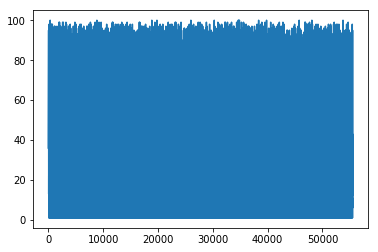

In [379]:
plt.plot(dfclean['killPlace'].values)

In [375]:
dfclean

matchId  killPlace  kills  \
matchId        kills killPlace                                     
0000a43bce5eec 0     36         0000a43bce5eec         36      0   
                     37         0000a43bce5eec         37      0   
                     38         0000a43bce5eec         38      0   
                     39         0000a43bce5eec         39      0   
                     40         0000a43bce5eec         40      0   
                     41         0000a43bce5eec         41      0   
                     42         0000a43bce5eec         42      0   
                     43         0000a43bce5eec         43      0   
                     44         0000a43bce5eec         44      0   
                     45         0000a43bce5eec         45      0   
                     46         0000a43bce5eec         46      0   
                     47         0000a43bce5eec         47      0   
                     48         0000a43bce5eec         48      0   
                     49         0000a43bce5eec         49      0   
                     50         0000a43bce5eec         50      0   
                     51         0000a43bce5eec         51      0   
                     52         0000a43bce5eec         52      0   
                     53         0000a43bce5eec         53      0   
                     54         0000a43bce5eec         54      0   
                     55         0000a43bce5eec         55      0   
                     56         0000a43bce5eec         56      0   
                     57         0000a43bce5eec         57      0   
                     58         0000a43bce5eec         58      0   
                     59         0000a43bce5eec         59      0   
                     60         0000a43bce5eec         60      0   
                     61         0000a43bce5eec         61      0   
                     62         0000a43bce5eec         62      0   
                     63         0000a43bce5eec         63      0   
                     64         0000a43bce5eec         64      0   
                     65         0000a43bce5eec         65      0   
...                                        ...        ...    ...   
034a385dd060d4 0     53         034a385dd060d4         53      0   
                     56         034a385dd060d4         56      0   
                     57         034a385dd060d4         57      0   
                     62         034a385dd060d4         62      0   
                     63         034a385dd060d4         63      0   
                     66         034a385dd060d4         66      0   
                     67         034a385dd060d4         67      0   
                     74         034a385dd060d4         74      0   
                     82         034a385dd060d4         82      0   
                     87         034a385dd060d4         87      0   
                     93         034a385dd060d4         93      0   
                     94         034a385dd060d4         94      0   
                     95         034a385dd060d4         95      0   
               1     24         034a385dd060d4         24      1   
                     25         034a385dd060d4         25      1   
                     29         034a385dd060d4         29      1   
                     31         034a385dd060d4         31      1   
                     33         034a385dd060d4         33      1   
                     35         034a385dd060d4         35      1   
                     37         034a385dd060d4         37      1   
                     39         034a385dd060d4         39      1   
                     41         034a385dd060d4         41      1   
                     43         034a385dd060d4         43      1   
               2     15         034a385dd060d4         15      2   
                     18         034a385dd060d4         18      2   
                     19         034a385dd060d4         19      2   
                     20    

In [333]:
df5['winPlacePerc']

matchId         kills  killPlace
0000a43bce5eec  0      36           0.8889
                       37           0.7778
                       38           0.7778
                       39           0.7407
                       40           0.6667
                       41           0.6667
                       42           0.6667
                       43           0.6667
                       44           0.6667
                       45           0.6296
                       46           0.5926
                       47           0.5926
                       48           0.5926
                       49           0.5556
                       50           0.5556
                       51           0.5556
                       52           0.5185
                       53           0.5185
                       54           0.4815
                       55           0.4444
                       56           0.4074
                       57           0.4074
                     

In [304]:
#x = df3.groupby(['matchId','kills']).apply(lambda x:x)

KeyboardInterrupt: 

In [ ]:
for x in df3.groupby(['matchId','kills']):
    

In [279]:
l=[]
for i in df3.groupby(''):
    for j in i.groupby('')
    print(i)
    #l.append(i.sort_values(by='killPlace'))

(0,                             Id         groupId         matchId  assists  \
matchId                                                                   
0000a43bce5eec  ffc5bf94121ebc  599d924f8a02db  0000a43bce5eec        0   
0000a43bce5eec  13228c696667a8  97364d4199bf30  0000a43bce5eec        0   
0000a43bce5eec  17f3544a0fdde4  236ab9e9c081b9  0000a43bce5eec        0   
0000a43bce5eec  de3ddbf280477e  9cf70fed874fa1  0000a43bce5eec        0   
0000a43bce5eec  3d96e46bfa404c  236ab9e9c081b9  0000a43bce5eec        0   
0000a43bce5eec  5d03716c2b3622  b431ffe23c623b  0000a43bce5eec        0   
0000a43bce5eec  8d049956935af0  599d924f8a02db  0000a43bce5eec        0   
0000a43bce5eec  486907e7ef0909  7bd08592bb25e2  0000a43bce5eec        1   
0000a43bce5eec  997b90d5130755  97364d4199bf30  0000a43bce5eec        0   
0000a43bce5eec  f99da346f1a999  8a2bf1adcd967d  0000a43bce5eec        0   
0000a43bce5eec  f806332c66c741  909fe185a8cdec  0000a43bce5eec        0   
0000a43bce5eec  aa43c

(1,                             Id         groupId         matchId  assists  \
matchId                                                                   
0000a43bce5eec  10ed15afafb7ec  4d1bbbc19b9084  0000a43bce5eec        1   
0000a43bce5eec  770fdf888c099b  c0f2e306380d3c  0000a43bce5eec        0   
0000a43bce5eec  5c4096331b83ce  f21c5900e6a0cd  0000a43bce5eec        0   
0000a43bce5eec  644002b3245a5c  8ebb76fe544c27  0000a43bce5eec        1   
0000a43bce5eec  2e13f3a9112980  9cf70fed874fa1  0000a43bce5eec        0   
0000a43bce5eec  0d3fbb7d4b168c  909fe185a8cdec  0000a43bce5eec        0   
0000a43bce5eec  c997f631899b4c  909fe185a8cdec  0000a43bce5eec        0   
0000a43bce5eec  b3e5169419ca41  a572193b2af137  0000a43bce5eec        1   
0000a43bce5eec  566609585ba531  8a2bf1adcd967d  0000a43bce5eec        0   
0000a43bce5eec  8eb803fb4b5d0a  b947dfc5cf2d02  0000a43bce5eec        0   
0000a43bce5eec  94d5300df5bec8  ca058240046b4c  0000a43bce5eec        0   
0000a43bce5eec  4541c

KeyboardInterrupt: 

In [275]:
df4 = df3.sort_values('kills')

KeyboardInterrupt: 

In [ ]:
df4.head()

In [273]:
display_all(df4.head().T)

matchId,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec
Id,ffc5bf94121ebc,13228c696667a8,10ed15afafb7ec,17f3544a0fdde4,de3ddbf280477e
groupId,599d924f8a02db,97364d4199bf30,4d1bbbc19b9084,236ab9e9c081b9,9cf70fed874fa1
matchId,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec,0000a43bce5eec
assists,0,0,1,0,0
boosts,3,0,3,0,0
damageDealt,19.35,0,151.8,0,74.88
DBNOs,0,0,1,0,0
headshotKills,0,0,1,0,0
heals,0,0,2,0,0
killPlace,48,83,23,90,63


## Plotagem

## Plotagem em um Match

## l____________________________________________________________________l

In [33]:
df4.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
matchId,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,ffc5bf94121ebc,599d924f8a02db,0000a43bce5eec,0,3,19.35,0,0,0,48,...,0,0.0,0,50.880,0,0,2438.00,4,1500,0.5926
0000a43bce5eec,13228c696667a8,97364d4199bf30,0000a43bce5eec,0,0,0.00,0,0,0,83,...,0,0.0,0,0.000,0,0,13.59,1,1433,0.1111
0000a43bce5eec,10ed15afafb7ec,4d1bbbc19b9084,0000a43bce5eec,1,3,151.80,1,1,2,23,...,0,159.9,0,6.545,0,0,3250.00,4,1480,1.0000
0000a43bce5eec,17f3544a0fdde4,236ab9e9c081b9,0000a43bce5eec,0,0,0.00,0,0,0,90,...,0,0.0,0,0.000,0,0,0.00,0,1547,0.0370
0000a43bce5eec,de3ddbf280477e,9cf70fed874fa1,0000a43bce5eec,0,0,74.88,0,0,0,63,...,0,0.0,0,0.000,0,0,252.90,3,1507,0.2963


In [34]:
%time dfa, _, _ = proc_df(df4)

mt = dfa.copy()

CPU times: user 204 ms, sys: 4 ms, total: 208 ms
Wall time: 580 ms


In [35]:
def rank(a):
    b = np.asarray(list(set(np.sort(a))))
    for n,i in enumerate(a):
        a[n] = np.where(b==i)[0]
    return a
  
    

In [36]:
def norma(a):
    for n,i in enumerate(a):
        a[n] = float(a[n] / a.max())
    return a

In [37]:
def feat_eng(df,cols):
    newdf = pd.DataFrame()
    %time
    count=0
    for i, ndf in df.groupby(level=0):
        count+=1
        print(count, end='\r')
        for c in cols:
            serie=ndf[c]
            rank(np.asarray(serie))
            ndf[c + 'Pos'] = serie
        newdf = pd.concat( (newdf, ndf), axis=0)
    return newdf

In [104]:
def test(dff,cols):
    newdf = pd.DataFrame()
    %time
    count=0
    for i, ndf in dff.groupby(level=0):
        count+=1
        print(count, end='\r')
        print(i)
        break
    print(count)

In [105]:
cols = list(['assists', 'boosts', 'damageDealt', 'DBNOs', \
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', \
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', \
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', \
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', \
       'weaponsAcquired', 'winPoints'])


In [108]:
def feat_eng2(df,cols):
    newdf = pd.DataFrame()
    %time
    count=0
    print(len(set(df['matchId'])))
    for mi in set(df['matchId']):
        ndf = df[df['matchId']==mi]
        count+=1
        print(count, end='\r')
        for c in cols:
            #serie=ndf[c]
            #serie = serie / (np.max(serie) - np.min(serie))
            #serie=norma(serie)
            print(c)
            print(count, end ='\r')
            ndf['pos' + c] = normalize(np.asarray(ndf[c]).reshape(1,-1),axis=0).reshape(len(ndf))
            #print(ndf.shape, pd.DataFrame(serie).shape)
        newdf = pd.concat( (newdf, ndf), axis=0)
    return newdf

In [146]:
mt2 = mt.copy()
mt2.set_index('matchId', inplace = True)
#mt2.head(8)

,Id,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
matchId,,,,,,,,,,,,,,,,,,,,,
1,4443029,711556,0,3,19.35,0,0,0,48,1000,...,0,0.000,0,50.880,0,0,2438.00,4,1500,0.5926
1,331987,1199250,0,0,0.00,0,0,0,83,1382,...,0,0.000,0,0.000,0,0,13.59,1,1433,0.1111
1,293764,612351,1,3,151.80,1,1,2,23,1308,...,0,159.900,0,6.545,0,0,3250.00,4,1480,1.0000
1,415831,280836,0,0,0.00,0,0,0,90,1449,...,0,0.000,0,0.000,0,0,0.00,0,1547,0.0370
1,3860556,1244160,0,0,74.88,0,0,0,63,1411,...,0,0.000,0,0.000,0,0,252.90,3,1507,0.2963
1,1068895,280836,0,0,78.69,0,0,0,89,1244,...,0,0.000,0,0.000,0,0,22.07,1,1411,0.0370
1,1616288,1427215,0,1,121.60,1,0,3,57,1246,...,0,1.386,0,0.000,0,1,737.30,7,1453,0.4074
1,2449703,711556,0,3,80.48,0,0,0,46,1000,...,0,0.000,0,141.600,0,0,2308.00,3,1500,0.5926


In [147]:
mt2['mid'] = mt2.index

In [227]:
for c in cols:
    x = np.asarray(mt2.groupby('mid')[c].apply(lambda x: normalize(np.asarray(x).reshape(1,-1))))
    l=[]
    for i in x:
        for j in i:
            l.extend(j)
    mt2.insert(value = l, column = 'pos_'+c, loc=0)
    

In [228]:
mt2.head()

,pos_winPoints,pos_weaponsAcquired,pos_walkDistance,pos_vehicleDestroys,pos_teamKills,pos_swimDistance,pos_roadKills,pos_rideDistance,pos_revives,pos_rankPoints,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,mid
matchId,,,,,,,,,,,,,,,,,,,,,
1,0.103185,0.110516,0.143184,0.0,0.0,0.307944,0.0,0.000000,0.0,0.0,...,0.0,0,50.880,0,0,2438.00,4,1500,0.5926,1
1,0.098576,0.027629,0.000798,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000,0,0,13.59,1,1433,0.1111,1
1,0.101809,0.110516,0.190873,0.0,0.0,0.039613,0.0,0.049895,0.0,0.0,...,159.9,0,6.545,0,0,3250.00,4,1480,1.0000,1
1,0.106418,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000,0,0,0.00,0,1547,0.0370,1
1,0.103666,0.082887,0.014853,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000,0,0,252.90,3,1507,0.2963,1


In [38]:
from sklearn.preprocessing import normalize

In [200]:
mt2.drop('xxxxx', inplace=True, axis = 1)

In [233]:
newdf=mt2.copy()

## l_____________________________________________________l

In [237]:
newdf['mid']

matchId
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
1        1
      ... 
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
604    604
Name: mid, Length: 55418, dtype: int64

In [235]:
display_all(newdf.head(100).T)

matchId,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2
pos_winPoints,1.031845e-01,9.857563e-02,0.101809,0.106418,1.036661e-01,9.706226e-02,9.995143e-02,1.031845e-01,1.071056e-01,1.016024e-01,1.042164e-01,1.154979e-01,9.740621e-02,1.004330e-01,1.019463e-01,0.099264,1.086189e-01,1.071056e-01,1.067616e-01,1.031845e-01,1.035973e-01,9.912595e-02,9.775016e-02,9.974506e-02,1.031845e-01,1.038037e-01,1.009145e-01,1.033221e-01,9.719984e-02,1.038724e-01,1.002266e-01,1.037349e-01,1.104763e-01,1.000202e-01,1.031845e-01,1.080686e-01,9.651194e-02,1.031845e-01,9.988264e-02,1.031158e-01,9.953869e-02,1.046291e-01,1.033909e-01,0.104079,0.101396,9.988264e-02,1.095820e-01,1.072431e-01,9.836926e-02,1.046979e-01,9.685589e-02,1.036661e-01,1.015336e-01,9.974506e-02,1.018775e-01,1.046979e-01,1.031845e-01,1.007081e-01,1.020839e-01,1.031845e-01,9.623678e-02,1.025654e-01,1.025654e-01,1.031845e-01,1.033221e-01,1.017400e-01,9.788774e-02,9.995143e-02,9.960748e-02,1.070368e-01,1.039412e-01,1.015336e-01,1.059361e-01,9.864442e-02,1.050419e-01,1.009145e-01,1.035973e-01,1.020151e-01,1.029094e-01,1.022903e-01,1.146724e-01,1.046979e-01,0.098576,9.788774e-02,1.035285e-01,1.031845e-01,1.004330e-01,1.029782e-01,1.020839e-01,1.044915e-01,1.007081e-01,0.102634,1.031845e-01,1.018775e-01,1.011896e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
pos_weaponsAcquired,1.105158e-01,2.762895e-02,0.110516,0.000000,8.288684e-02,2.762895e-02,1.934026e-01,8.288684e-02,8.288684e-02,2.762895e-02,8.288684e-02,1.657737e-01,1.381447e-01,1.105158e-01,0.000000e+00,0.027629,5.525790e-02,2.762895e-02,8.288684e-02,5.525790e-02,1.381447e-01,1.105158e-01,8.288684e-02,2.762895e-02,1.381447e-01,1.934026e-01,1.381447e-01,8.288684e-02,0.000000e+00,5.525790e-02,8.288684e-02,1.105158e-01,1.105158e-01,8.288684e-02,2.762895e-02,1.934026e-01,2.762895e-02,8.288684e-02,1.105158e-01,5.525790e-02,5.525790e-02,1.381447e-01,2.762895e-02,0.110516,0.027629,1.105158e-01,1.105158e-01,2.210316e-01,2.762895e-02,1.105158e-01,2.762895e-02,2.210316e-01,2.762895e-02,2.762895e-02,5.525790e-02,8.288684e-02,2.762895e-02,1.657737e-01,1.105158e-01,1.657737e-01,2.762895e-02,2.762895e-02,2.762895e-02,0.000000e+00,8.288684e-02,5.525790e-02,1.105158e-01,2.762895e-02,5.525790e-02,2.762895e-02,1.657737e-01,5.525790e-02,5.525790e-02,1.105158e-01,5.525790e-02,1.105158e-01,2.762895e-02,3.315474e-01,1.381447e-01,1.105158e-01,5.525790e-02,8.288684e-02,0.055258,2.762895e-02,1.105158e-01,1.381447e-01,5.525790e-02,5.525790e-02,2.762895e-02,1.105158e-01,1.381447e-01,0.082887,1.381447e-01,1.105158e-01,8.288684e-02,5.106429e-02,0.076596,5.106429e-02,1.276607e-01,1.021286e-01
pos_walkDistance,1.431839e-01,7.981416e-04,0.190873,0.000000,1.485283e-02,1.296173e-03,4.330168e-02,1.355490e-01,1.578664e-01,9.085541e-04,1.443585e-01,1.704934e-01,1.105887e-01,7.241417e-03,1.207490e-03,0.003298,1.030125e-02,5.659229e-04,1.901680e-01,3.754026e-03,1.793616e-01,9.402683e-02,1.225696e-01,4.561564e-03,1.476474e-01,1.225109e-01,9.737445e-02,1.844711e-01,0.000000e+00,1.773648e-02,1.448283e-02,1.083570e-01,1.754854e-01,1.995060e-01,1.405410e-03,1.512299e-01,4.957992e-03,1.286188e-02,3.813930e-02,9.144271e-03,1.286776e-01,8.233955e-02,3.054551e-04,0.138838,0.004344,2.019140e-01,1.720791e-01,1.409522e-01,1.028363e-03,1.958648e-01,2.867202e-03,1.560458e-01,2.195330e-03,1.095316e-03,5.489499e-03,1.825918e-01,5.794896e-03,1.195157e-01,1.826505e-01,7.123957e-02,4.928627e-03,3.085090e-03,1.017205e-02,1.411283e-03,1.599220e-01,6.383958e-03,1.061252e-01,7.717131e-03,7.593797e-03,7.024116e-03,1.299109e-01,2.577075e-03,1.581013e-01,2.887757e-02,1.324950e-01,1.179300e-01,1.458268e-03,4.524564e-02,1.958648e-01,4.604437e-03,1.368411e-02,6.983005e-02,0.020420,4.869310e-03,1.622124e-01,7.123957e-02,2.645789e-03,4.295517e-03,1.112347e-02,1.275617e-01,9.432048e-02,0.140482,1.602743e-01,9.420302e-02,7.288401e-0

In [249]:
newdf = newdf.iloc[:: -1]

In [251]:
df_tr = newdf.drop(['winPlacePerc'],axis=1)
y_tr = newdf['winPlacePerc']

n_valid = 1000  # same as Kaggle's test set size
n_tr = len(df_tr)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_tr)
X_train, X_valid = split_vals(df_tr, n_tr)
y_train, y_valid = split_vals(y_tr, n_tr)
X_train.shape, y_train.shape, X_valid.shape

m = RandomForestRegressor(n_jobs=-1, n_estimators = 50 )
m.fit(X_train, y_train)
print_score(m)

((54418, 53), (54418,), (1000, 53))

In [253]:
imae(m.predict(X_valid), y_valid)

0.052676425113491555

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [245]:
X_valid

,pos_winPoints,pos_weaponsAcquired,pos_walkDistance,pos_vehicleDestroys,pos_teamKills,pos_swimDistance,pos_roadKills,pos_rideDistance,pos_revives,pos_rankPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,mid
matchId,,,,,,,,,,,,,,,,,,,,,
593,0.110674,0.110056,0.026491,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,466.30,5,1603,593
593,0.100870,0.066034,0.016026,0.0,0.0,0.0,0.0,0.000000,0.213201,-0.104828,...,1,0.0,0,0.0,0,0,282.10,3,1461,593
593,0.103563,0.264135,0.064935,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,1143.00,12,1500,593
593,0.107568,0.066034,0.066128,0.0,0.0,0.0,0.0,0.014792,0.213201,-0.104828,...,1,296.5,0,0.0,0,0,1164.00,3,1558,593
593,0.104323,0.088045,0.126916,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,2234.00,4,1511,593
593,0.103563,0.022011,0.002623,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,46.17,1,1500,593
593,0.106187,0.066034,0.008425,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,148.30,3,1538,593
593,0.103563,0.044023,0.007919,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.104828,...,0,0.0,0,0.0,0,0,139.40,2,1500,593
593,0.111917,0.132068,0.177308,0.0,0.0,0.0,0.0,0.165328,0.000000,-0.104828,...,0,3314.0,0,0.0,0,0,3121.00,6,1621,593
